In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('..')

import src as sc

COLOR_MAP = {"light_orange":"#E69F00",
             "light_blue":"#56B4E9",
             "teal":"#009E73",
             "yellow":"#F0E442",
             "dark_blue":"#0072B2",
             "dark_orange":"#D55E00",
             "pink":"#CC79A7",
             "purple":"#9370DB",
             "black":"#000000",
             "silver":"#DCDCDC"}

cmap = {"Man":COLOR_MAP["light_blue"],
       "Non-Man":COLOR_MAP["dark_blue"],
       "White":COLOR_MAP["light_orange"],
       "Non-White":COLOR_MAP["dark_orange"]}
lmap = {"Man":"--",
       "Non-Man":"-",
       "White":"--",
       "Non-White":"-"}


# Load Data

In [2]:
# Load data
hall_df, student_df, art_df = sc.load_data()

# Get art_capacity_df.
art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                    categories = ["gender","race"])

# Get building_capacity_df.
building_capacity_df = sc.get_building_capacity_df()
building_capacity =  building_capacity_df.values
art_capacity = art_capacity_df["capacity"].values

# Fill buildings
sc.fill_buildings(student_df = student_df, hall_df = hall_df)

art_capacity_df

,tuple,string,original_index,capacity
0,"(1, 1)","Woman, White",1104,100.0
1,"(1, 2)","Woman, Asian",302,4.0
2,"(1, 3)","Woman, Hispanics of any race",1863,4.0
3,"(1, 4)","Woman, Black or African American",997,7.0
4,"(1, 6)","Woman, American Indian or Alaska Native",1001,15.0
5,"(2, 1)","Man, White",1441,100.0
6,"(2, 2)","Man, Asian",83,35.0
7,"(2, 3)","Man, Hispanics of any race",957,100.0
8,"(2, 4)","Man, Black or African American",1048,54.0
9,"(2, 5)","Man, Two or more races",356,1.0


In [3]:
# Current assigment
current_assignment = pd.read_csv("current_assignment_df.csv", index_col = 0)
current_assignment.sum(axis = 0)

Woman, White                                51
Woman, Asian                                 2
Woman, Hispanics of any race                 0
Woman, Black or African American             0
Woman, American Indian or Alaska Native      0
Man, White                                 285
Man, Asian                                   3
Man, Hispanics of any race                  18
Man, Black or African American              13
Man, Two or more races                       0
Man, American Indian or Alaska Native        0
dtype: int64

In [4]:
# Get baseline stats.
df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
for i in range(10):
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    bs_gender = sc.baseline_average_value(category = "gender", in_group = "Man")
    bs_race = sc.baseline_average_value(category = "race", in_group = "White")
    df_baseline[i] = list(bs_gender) + list(bs_race)
    
df_stats = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

mean = [np.around(d,decimals = 3) for d in df_baseline.mean(axis = 1)]
error = [np.around(d,decimals = 3) for d in df_baseline.std(axis = 1)]

df_stats["baseline_mean"] = mean
df_stats["baseline_error"] = error
df_stats

,baseline_mean,baseline_error
Man,12.371,0.115
Non-Man,2.454,0.012
White,13.288,0.123
Non-White,1.601,0.017


In [5]:
# for i in [1,10,20]:
#     cost_df = sc.compute_cost_matrix(art_df = art_df, 
#                                         hall_df = hall_df,
#                                         categories = ["gender","race"],
#                                         alpha = -1,
#                                         beta = 10**i)

#     C = cost_df.values
#     num_buildings = cost_df.shape[0]
#     num_arts = cost_df.shape[1]
#     building_capacity = building_capacity_df.values
#     art_capacity = art_capacity_df["capacity"].values

#     P = current_assignment.values
#     t = np.trace(np.matmul(C.transpose(),P))
#     print(t)

51.0
47.803549424214275
33.81818243555009


# Initialize Parameters

#### Calibrate lambda and tau factors

In [6]:
# Current assigment
current_assignment = pd.read_csv("current_assignment_df.csv", index_col = 0).values

df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
num_buildings =  building_capacity_df.shape[0]

# Find the appropriate scaling between the first and second terms of the optimization objective
# Fix alpha = -1
# Vary beta as follows: beta = [0.01 0.1 1 10 100 1000]
# For each beta, compute first term
# Compute second and third terms without lambda
# See on average how large is the first term compared 
# to the second and third terms

beta_values = np.array([1000,100000,1000000000])
term1 = np.zeros((beta_values.shape[0],10))
term2 = np.zeros((beta_values.shape[0],10))
term3 = np.zeros((beta_values.shape[0],10))
for m in range(beta_values.shape[0]):
    # Compute full n_buildings x n_artworks cost matrix.
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta_values[m])
    num_arts = cost_df.shape[1]
    t = np.arange(1,num_arts + 1)
    for k in range(10):
        # Pick a random permutation in S
        P = np.random.randn(num_buildings,num_arts)  
        # Projection
        for ii in range(num_buildings):
            v = P[ii,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[ii]=v * building_capacity[ii]
            else:
                mu = v[np.argsort(-v)]
                tmp = np.divide(np.cumsum(mu)-building_capacity[ii],t)
                idx_negative = np.argwhere(mu-tmp<=0)
                try:
                    idx_neg = idx_negative[0]
                    idx_neg = idx_neg.item()
                except:
                    idx_neg = -1
                theta = (np.sum(mu[0:idx_neg])-building_capacity[ii])/(idx_neg)
                P[ii,:] =  np.maximum(P[ii,:]-theta,0)  
        term1[m,k] = np.trace(np.matmul(np.transpose(cost_df.values),P))
        term2[m,k] = np.linalg.norm(np.sum(P,axis=0)-art_capacity)**2
        term3[m,k] = np.linalg.norm(P-current_assignment)**2

term1_avg = np.mean(term1)
term2_avg = np.mean(term2)
term3_avg = np.mean(term3)

print(f"term 1 mean = {term1_avg}, std = {np.std(term1)}")
print(f"term 2 mean = {term2_avg}, std = {np.std(term2)}")
print(f"term 3 mean = {term3_avg}, std = {np.std(term3)}")
print(" ")

norm_lam_factor = term1_avg/term2_avg
norm_tau_factor = term1_avg/term3_avg

# norm_lam_factor = 1/ np.std(term2)
# norm_tau_factor = 1/ np.std(term3)

print(f"norm_lam_factor = {norm_lam_factor}")
print(f"norm_tau_factor = {norm_tau_factor}")

term 1 mean = 4.571773030219925, std = 1.730100515883669
term 2 mean = 31117.92309471151, std = 894.9389993487638
term 3 mean = 33622.16692466515, std = 28.449138088277508
 
norm_lam_factor = 0.00014691767880218513
norm_tau_factor = 0.0001359749667671206


In [7]:
# Current assigment
current_assignment = pd.read_csv("current_assignment_df.csv", index_col = 0).values

df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
num_buildings =  building_capacity_df.shape[0]

# Find the appropriate scaling between the first and second terms of the optimization objective
# Fix alpha = -1
# Vary beta as follows: beta = [0.01 0.1 1 10 100 1000]
# For each beta, compute first term
# Compute second and third terms without lambda
# See on average how large is the first term compared 
# to the second and third terms

beta_values = np.array([1000,100000,1000000000])
term1 = np.zeros((beta_values.shape[0],10))
term2 = np.zeros((beta_values.shape[0],10))
term3 = np.zeros((beta_values.shape[0],10))
for m in range(beta_values.shape[0]):
    # Compute full n_buildings x n_artworks cost matrix.
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta_values[m])
    num_arts = cost_df.shape[1]
    t = np.arange(1,num_arts + 1)
    for k in range(10):
        # Pick a random permutation in S
        P = np.random.randn(num_buildings,num_arts)  
        # Projection
        for ii in range(num_buildings):
            v = P[ii,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[ii]=v * building_capacity[ii]
            else:
                mu = v[np.argsort(-v)]
                tmp = np.divide(np.cumsum(mu)-building_capacity[ii],t)
                idx_negative = np.argwhere(mu-tmp<=0)
                try:
                    idx_neg = idx_negative[0]
                    idx_neg = idx_neg.item()
                except:
                    idx_neg = -1
                theta = (np.sum(mu[0:idx_neg])-building_capacity[ii])/(idx_neg)
                P[ii,:] =  np.maximum(P[ii,:]-theta,0)  
        term1[m,k] = np.trace(np.matmul(np.transpose(cost_df.values),P))
        term2[m,k] = norm_lam_factor * np.linalg.norm(np.sum(P,axis=0)-art_capacity)**2
        term3[m,k] = norm_tau_factor * np.linalg.norm(P-current_assignment)**2

term1_avg = np.mean(term1)
term2_avg = np.mean(term2)
term3_avg = np.mean(term3)

print(f"term 1 mean = {term1_avg}, std = {np.std(term1)}")
print(f"term 2 mean = {term2_avg}, std = {np.std(term2)}")
print(f"term 3 mean = {term3_avg}, std = {np.std(term3)}")
print(" ")

term 1 mean = 4.480415495505427, std = 1.706923913242441
term 2 mean = 4.546584889338275, std = 0.16003633167295397
term 3 mean = 4.570490979042641, std = 0.005108869510553155
 


# Choose Optimal lambda and tau Parameters

In [8]:
cost_dict = {}
opt_dict = {}

betas = []

#### beta = 0.01

In [9]:
beta = 0.01
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [10]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [.1, 1, 10, 100, 1000]
scaled_tau = [.1, 1, 10, 100]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 100

In [20]:
beta = 100
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [21]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 10^8

In [12]:
beta = 10**8
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [13]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 10^11

In [15]:
beta = 10 ** 11
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [16]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

#### beta = 10 ^15

In [17]:
beta = 10 ** 15
betas.append(beta)
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)

cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_dict[beta] = cost_df

In [18]:
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]
for lam in scaled_lam:
    for tau in scaled_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*lam, 
                             tau=norm_tau_factor*tau, 
                             init=2) 

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

opt_dict[beta] = df_optimized.copy()

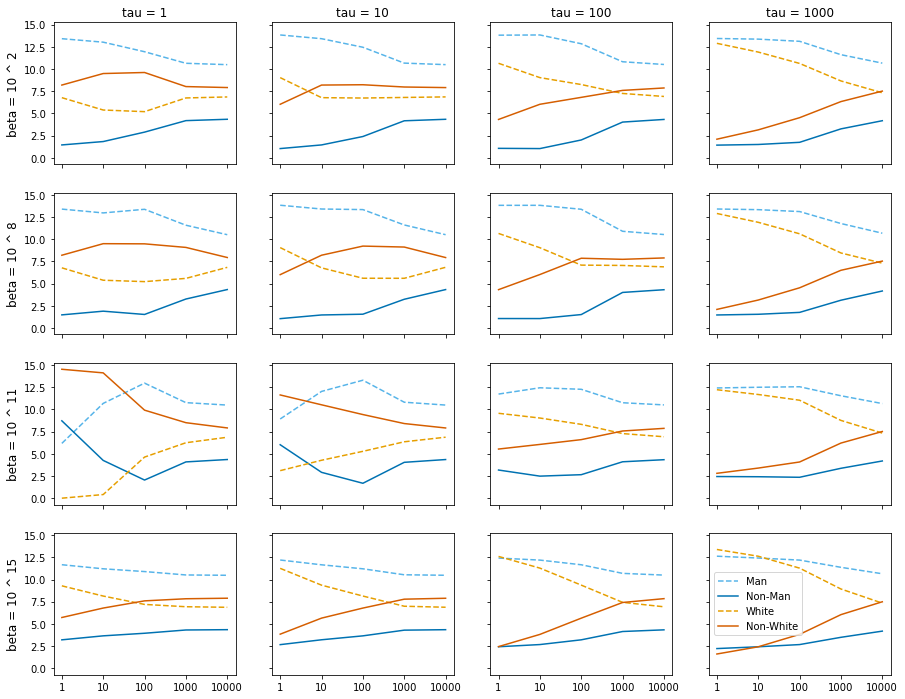

In [23]:
bbetas = [10**2, 10**8, 10**11, 10**15]

fig, ax = plt.subplots(len(bbetas),4,figsize = (15,12), sharex = True, sharey = True)

for i in range(len(bbetas)):
    beta = bbetas[i]
    df_optimized = opt_dict[beta]
    for j in range(len(scaled_tau)):
        tau = scaled_tau[j]
        tau_idx = [d for d in df_optimized.index if float(d.split("_")[2]) == tau]
        for c in df_optimized.columns:
            ax[i, j].plot(df_optimized.loc[tau_idx,c].values, 
                                   color = cmap[c],
                                   linestyle = lmap[c], 
                                   label = c)
            ax[i, j].set_xticks([i for i in range(len(scaled_lam))])
            ax[i, j].set_xticklabels(scaled_lam)

ax[i, j].legend()
for i in range(len(bbetas)):
    ax[i,0].set_ylabel(f"beta = 10 ^ {int(np.log10(bbetas[i]))}", fontsize = 12)
for j in range(len(scaled_tau)):
    ax[0, j].set_title(f"tau = {scaled_tau[j]}", fontsize = 12)
    
plt.show()

In [97]:
cost_dict[10**11]

,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,0.261229,0.0,0.0,0.0,0.210799,0.197691,0.000195,0.051421,0.042451,0.0,0.236215
anderson,0.275474,0.0,0.0,0.0,0.181087,0.23529,0.000024,0.034664,0.02302,0.0,0.250442
ballou,0.26386,0.0,0.0,0.0,0.213357,0.197628,0.000168,0.05051,0.035742,0.0,0.238735
capen_house,0.099263,0.099263,0.099263,0.099263,0.099263,0.099263,0.099263,0.099263,0.092123,0.014511,0.099263
clic,0.275474,0.0,0.0,0.0,0.181087,0.23529,0.000024,0.034664,0.02302,0.0,0.250442
dental_school,0.170978,0.001205,0.021267,0.001336,0.170978,0.163485,0.044578,0.141787,0.117769,0.000007,0.166611
eaton_hall,0.259653,0.0,0.0,0.0,0.209491,0.198805,0.000277,0.05333,0.04366,0.0,0.234783
fine_arts_house,0.278377,0.0,0.0,0.0,0.182774,0.196401,0.000201,0.051358,0.039297,0.0,0.251591
gifford_house,0.139642,0.001681,0.050665,0.040513,0.139642,0.137001,0.10702,0.125282,0.118906,0.000006,0.139642
goddard_chapel,0.147117,0.00143,0.039249,0.022537,0.147117,0.142933,0.092963,0.133163,0.126362,0.000011,0.147117


In [96]:
art_capacity_df

,tuple,string,original_index,capacity
0,"(1, 1)","Woman, White",1104,100.0
1,"(1, 2)","Woman, Asian",302,4.0
2,"(1, 3)","Woman, Hispanics of any race",1863,4.0
3,"(1, 4)","Woman, Black or African American",997,7.0
4,"(1, 6)","Woman, American Indian or Alaska Native",1001,15.0
5,"(2, 1)","Man, White",1441,100.0
6,"(2, 2)","Man, Asian",83,35.0
7,"(2, 3)","Man, Hispanics of any race",957,100.0
8,"(2, 4)","Man, Black or African American",1048,54.0
9,"(2, 5)","Man, Two or more races",356,1.0


Woman, White                                       0
Woman, Asian                                4.752924
Woman, Hispanics of any race                2.747411
Woman, Black or African American            3.024258
Woman, American Indian or Alaska Native            0
Man, White                                 16.600336
Man, Asian                                  3.924605
Man, Hispanics of any race                  0.458889
Man, Black or African American               1.30786
Man, Two or more races                      4.183718
Man, American Indian or Alaska Native              0
dtype: object

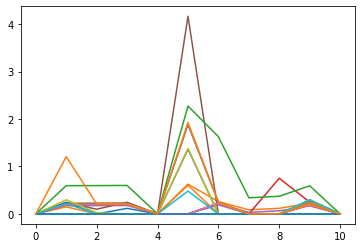

In [101]:
assignment_df = sc.learn_optimal_assignment(cost_dict[10**11], 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*1, 
                             tau=norm_tau_factor*1000, 
                             init=2) 

for i in assignment_df.index:
    plt.plot(assignment_df.loc[i,:].values)
    
assignment_df.sum(axis = 0)

In [164]:
def learn_optimal_assignment(cost_df, building_capacity_df, art_capacity_df, current_assignment, lam, tau,init):
    """ Return n_buildings x n_artworkks assignment array
    """
    C = cost_df.values
    num_buildings = cost_df.shape[0]
    num_arts = cost_df.shape[1]
    building_capacity = building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values

    dt = 0.5 * (1/((lam * num_buildings) + tau)) #step size
    t = np.arange(1,num_arts + 1)

    ones_vector= np.ones((num_buildings,1))

    # Initialize assignment array.
    if init==1:
        P = np.eye(num_buildings,num_arts)
    elif init==2:
        P = 1/(num_arts)*np.divide(np.ones((num_buildings,num_arts)),building_capacity)
    elif init==3:
        P = current_assignment
    else:
        P = np.random.randn(num_buildings,num_arts)
        # Projection
        for i in range(num_buildings):
            v = P[i,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[i]=v * building_capacity[i]
            else:
                mu = v[np.argsort(-v)]
                tmp = np.divide(np.cumsum(mu)-building_capacity[i],t)
                idx_negative = np.argwhere(mu-tmp<=0)
                try:
                    idx_neg = idx_negative[0]
                    idx_neg = idx_neg.item()
                except:
                    idx_neg = -1
                theta = (np.sum(mu[0:idx_neg])-building_capacity[i])/(idx_neg)
                P[i,:] =  np.maximum(P[i,:]-theta,0)

    for _ in range(100):
        # Gradient descent.
        term2b = np.matmul(ones_vector,np.matmul(np.transpose(ones_vector),P
                          )-np.transpose(art_capacity))

        P = P - dt*C - lam *dt*(term2b)- tau*dt*(P-current_assignment)

        # Projection
        for i in range(num_buildings):
            v = P[i,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[i]=v * building_capacity[i]
                print(np.sum(P[i]))
            else:
                mu = v[np.argsort(-v)]
                step_2_part_1 = (np.cumsum(mu) - building_capacity[i])/t
                K = np.argwhere(step_2_part_1 < mu)[-1][0] + 1
                theta = (np.sum(mu[:K]) - building_capacity[i]) / (K)
                

                P[i,:] =  np.maximum(P[i,:]-theta,0)
                print(P[i,:].sum(), building_capacity[i])
                print("")

    return pd.DataFrame(P, index = cost_df.index,
                   columns = art_capacity_df["string"].values)

learn_optimal_assignment(cost_dict[10**11], 
                             building_capacity_df, 
                             art_capacity_df, 
                             current_assignment, 
                             lam = norm_lam_factor*1, 
                             tau=norm_tau_factor*1000, 
                             init=2) 

222.0 [222]

2.0 [2]

36.0 [36]

1.0000000000000004 [1]

0.9999999999999999 [1]

4.999999999999999 [5]

1.0000000000000002 [1]

3.0000000000000004 [3]

24.000000000000007 [24]

15.0 [15]

2.0000000000000004 [2]

0.9999999999999999 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0000000000000002 [1]

1.0000000000000002 [1]

3.0 [3]

2.0 [2]

1.0 [1]

58.0 [58]

3.9999999999999996 [4]

222.00000000000003
2.0000000000000004 [2]

36.00000000000001 [36]

1.0 [1]

1.0 [1]

5.000000000000001 [5]

1.0000000000000002 [1]

2.9999999999999996 [3]

23.999999999999996 [24]

15.0 [15]

1.9999999999999998 [2]

1.0 [1]

7.000000000000001 [7]

1.0000000000000002 [1]

1.0 [1]

1.0000000000000002 [1]

1.0000000000000002 [1]

3.000000000000001 [3]

2.0 [2]

0.9999999999999999 [1]

58.00000000000001
4.0 [4]

221.99999999999997
2.0 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

5.0 [5]

0.9999999999999999 [1]

3.0000000000000004 [3]

24.0 [24]

14.999999999999996 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

0.99999

1.0 [1]

2.9999999999999996 [3]

2.0 [2]

1.0 [1]

58.000000000000014 [58]

4.0 [4]

221.99999999999994 [222]

1.9999999999999998 [2]

35.99999999999999 [36]

1.0 [1]

0.9999999999999999 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.0 [24]

14.999999999999998 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

0.9999999999999999 [1]

1.0 [1]

1.0 [1]

3.0 [3]

2.0 [2]

1.0 [1]

57.99999999999999 [58]

3.9999999999999996 [4]

222.0 [222]

2.0 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

3.0 [3]

24.000000000000004 [24]

15.000000000000002 [15]

1.9999999999999998 [2]

0.9999999999999999 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

3.0000000000000004 [3]

2.0000000000000004 [2]

1.0 [1]

57.999999999999986 [58]

4.000000000000001 [4]

222.0 [222]

1.9999999999999998 [2]

36.0 [36]

1.0 [1]

1.0 [1]

5.000000000000001 [5]

1.0 [1]

3.0000000000000004 [3]

24.0 [24]

15.0 [15]

2.0 [2]

0.9999999999999999 [1]

7.000000000000001 [7]

1.0 [1]

1


4.0 [4]

222.00000000000006 [222]

2.0000000000000004 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.000000000000004 [24]

15.000000000000004 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

3.0 [3]

2.0 [2]

0.9999999999999999 [1]

57.99999999999999 [58]

4.0 [4]

222.00000000000003 [222]

2.0000000000000004 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.000000000000004 [24]

15.000000000000004 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

2.9999999999999996 [3]

2.0 [2]

0.9999999999999999 [1]

57.99999999999999 [58]

4.0 [4]

222.00000000000006 [222]

2.0000000000000004 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.000000000000004 [24]

15.000000000000004 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

3.0 [3]

2.0 [2]

0.9999999999999999 [1]



222.00000000000003 [222]

2.0000000000000004 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.000000000000004 [24]

15.000000000000004 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

2.9999999999999996 [3]

2.0 [2]

0.9999999999999999 [1]

57.99999999999999 [58]

4.0 [4]

222.00000000000006 [222]

2.0000000000000004 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.000000000000004 [24]

15.000000000000004 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

3.0 [3]

2.0 [2]

0.9999999999999999 [1]

57.99999999999999 [58]

4.0 [4]

222.00000000000003 [222]

2.0000000000000004 [2]

35.99999999999999 [36]

1.0 [1]

1.0 [1]

4.999999999999999 [5]

1.0 [1]

2.9999999999999996 [3]

24.000000000000004 [24]

15.000000000000004 [15]

2.0 [2]

1.0 [1]

7.0 [7]

1.0 [1]

1.0 [1]

1.0 [1]

1.0 [1]

2.9999999999999996 [3]

2.0 [2]

0.9999999999999999 

,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,25.067655,1.876882,0.881449,0.884187,0,174.279859,2.911074,9.601601,5.621735,0.875557,0
anderson,0,0.261452,0.266019,0.268756,0,0.394374,0.296874,0.106529,0.14587,0.260126,0
ballou,3.0447,0.872829,0.877396,0.880134,0,25.276261,0.907219,0.604088,2.665868,0.871504,0
capen_house,0,0,0,0,0,0,0,0,0.746814,0.253186,0
clic,0,0.174934,0.179501,0.182238,0,0,0.210356,0.020011,0.059352,0.173608,0
dental_school,0,0.290747,0.151224,0.297115,0,3.948073,0.014815,0,0,0.298026,0
eaton_hall,0,0.19117,0.195737,0.198475,0,0,0.224773,0,0,0.189845,0
fine_arts_house,0,0.253652,0.258219,0.260956,0,1.665895,0.287799,0,0.021153,0.252326,0
gifford_house,3.572333,0.496179,0.148921,0.224572,0,18.347146,0,0,0.703962,0.506886,0
goddard_chapel,0.898081,0.877425,0.61036,0.733127,0,10.683977,0.255581,0.025301,0.029852,0.886296,0


In [ ]:
mu = np.array([1,2,3,4])

# Learn Optimal beta parameter

In [7]:
lam = norm_lam_factor * 1000
tau = norm_tau_factor * 1

print(f"lambda = {lam}")
print(f"tau = {tau}")
cost_dict_beta = {}

lambda = 0.15581091876720424
tau = 0.000143426155672036


In [12]:
orders = [-8,8,15]
df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
for i in orders:
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                        hall_df = hall_df,
                                        categories = ["gender","race"],
                                        alpha = -1,
                                        beta = 10 ** i)

    cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
    cost_dict_beta[i] = cost_df.copy()
    
    assignment_df = sc.learn_optimal_assignment(cost_df, 
                         building_capacity_df, 
                         art_capacity_df, 
                         current_assignment, 
                         lam = 0.0001, 
                         tau=0.0001, 
                         init=2) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized.loc[f"{10**i}",:] = list(os_gender) + list(os_race)

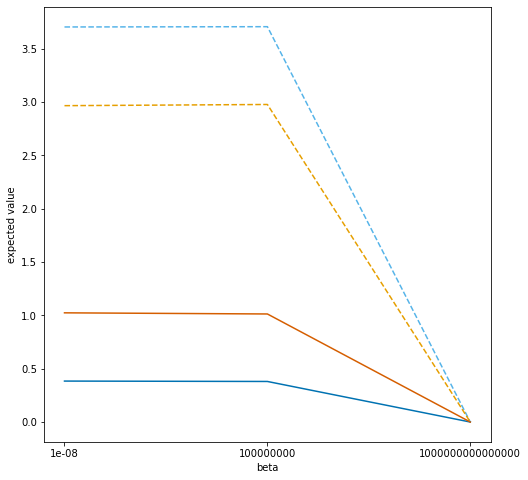

In [13]:
fig, ax = plt.subplots(figsize = (8,8))

for c in df_optimized.columns:
    ax.plot(df_optimized.loc[:,c].values, 
                           color = cmap[c],
                           linestyle = lmap[c], 
                           label = c)
    ax.set_xticks([i for i in range(len(orders))])
    ax.set_xticklabels([10**i for i in orders])
    
ax.set_xlabel("beta")
ax.set_ylabel("expected value")

plt.show()

In [14]:
cost_df

,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,0.09114,0.090482,0.090992,0.090931,0.091138,0.091138,0.091075,0.091125,0.091123,0.089717,0.091139
anderson,0.09119,0.090403,0.091024,0.090956,0.091186,0.091188,0.091104,0.091171,0.091167,0.089422,0.091189
ballou,0.091143,0.090472,0.090994,0.090925,0.091141,0.09114,0.091076,0.091127,0.091126,0.089714,0.091142
capen_house,0.090911,0.090911,0.090911,0.090911,0.090911,0.090911,0.090911,0.090911,0.09091,0.090893,0.090911
clic,0.09119,0.090403,0.091024,0.090956,0.091186,0.091188,0.091104,0.091171,0.091167,0.089422,0.091189
dental_school,0.090929,0.090884,0.09091,0.090885,0.090929,0.090928,0.090917,0.090927,0.090925,0.090838,0.090929
eaton_hall,0.09113,0.0905,0.090988,0.090928,0.091128,0.091128,0.091068,0.091116,0.091114,0.089771,0.091129
fine_arts_house,0.091147,0.090448,0.090991,0.090939,0.091143,0.091143,0.091081,0.091131,0.091129,0.089703,0.091146
gifford_house,0.090921,0.090873,0.090914,0.09091,0.090921,0.090921,0.090917,0.09092,0.090919,0.090863,0.090921
goddard_chapel,0.09092,0.090886,0.090915,0.090909,0.09092,0.09092,0.090915,0.090919,0.090918,0.090861,0.09092


In [15]:
assignment_df

,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,0,0,0,0,0,0,0,0,0,0,0
anderson,0,0,0,0,0,0,0,0,0,0,0
ballou,0,0,0,0,0,0,0,0,0,0,0
capen_house,0,0,0,0,0,0,0,0,0,0,0
clic,0,0,0,0,0,0,0,0,0,0,0
dental_school,0,0,0,0,0,0,0,0,0,0,0
eaton_hall,0,0,0,0,0,0,0,0,0,0,0
fine_arts_house,0,0,0,0,0,0,0,0,0,0,0
gifford_house,0,0,0,0,0,0,0,0,0,0,0
goddard_chapel,0,0,0,0,0,0,0,0,0,0,0


In [30]:
term1 = np.zeros((len(orders),10))
term2 = np.zeros((len(orders),10))
term3 = np.zeros((len(orders),10))
orders = [-2,-1,0,1,2,3,4,5,6]
for i in range(len(orders)):
    # Compute full n_buildings x n_artworks cost matrix.
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = 10 ** orders[i])
    num_arts = cost_df.shape[1]
    t = np.arange(1,num_arts + 1)
    for k in range(10):
        # Pick a random permutation in S
        P = np.random.randn(num_buildings,num_arts)  
        # Projection
        for ii in range(num_buildings):
            v = P[ii,:]
            if np.all(v>0):
                v = v/np.sum(v)
                P[ii]=v * building_capacity[ii]
            else:
                mu = v[np.argsort(-v)]
                tmp = np.divide(np.cumsum(mu)-building_capacity[ii],t)
                idx_negative = np.argwhere(mu-tmp<=0)
                try:
                    idx_neg = idx_negative[0]
                    idx_neg = idx_neg.item()
                except:
                    idx_neg = -1
                theta = (np.sum(mu[0:idx_neg])-building_capacity[ii])/(idx_neg)
                P[ii,:] =  np.maximum(P[ii,:]-theta,0)  
        term1[i,k] = np.trace(np.matmul(np.transpose(cost_df.values),P))
        term2[i,k] = .5 * lam * np.linalg.norm(np.sum(P,axis=0)-art_capacity)**2
        term3[i,k] = .5 * tau * np.linalg.norm(P-current_assignment)**2
        
print(f"term 1 mean = {np.mean(term1)}, std = {np.std(term1)}")
print(f"term 2 mean = {np.mean(term2)}, std = {np.std(term2)}")
print(f"term 3 mean = {np.mean(term3)}, std = {np.std(term3)}")
print(" ")


term 1 mean = 4.632631335305293, std = 2.0765476830403875
term 2 mean = 223.34403089310274, std = 5.870625637368731
term 3 mean = 2.2376573082320266, std = 0.0018602566527923213
 


In [31]:
term1[0,:]

array([4.80263294, 5.91131296, 3.58017754, 4.18129598, 3.94765209,
       4.30877668, 3.11235769, 3.51589464, 6.3896201 , 3.55000879])

In [27]:
term2[0,:]

array([220.70059943, 228.2995951 , 211.00900269, 226.24001217,
       226.4269891 , 218.9666548 , 233.4686197 , 220.63953016,
       224.48603439, 220.25013052])

In [28]:
term3[0,:]

array([2.23697115, 2.23744062, 2.24007995, 2.24034534, 2.24003254,
       2.23890413, 2.23897632, 2.23806879, 2.24030555, 2.2387631 ])

In [34]:
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = 10 ** orders[0])

cost_df

,"(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 6)","(2, 1)","(2, 2)","(2, 3)","(2, 4)","(2, 5)","(2, 6)"
aidekman,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anderson,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ballou,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
capen_house,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
clic,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dental_school,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eaton_hall,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fine_arts_house,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gifford_house,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
goddard_chapel,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = 10 ** orders[-1])

cost_df

,"(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 6)","(2, 1)","(2, 2)","(2, 3)","(2, 4)","(2, 5)","(2, 6)"
aidekman,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anderson,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ballou,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
capen_house,0.111167,0.111026,0.111127,0.111061,0.111005,0.11117,0.111143,0.111162,0.0,0.0,0.111139
clic,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dental_school,0.515193,0.0,0.0,0.0,0.484807,0.0,0.0,0.0,0.0,0.0,0.0
eaton_hall,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fine_arts_house,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gifford_house,0.508029,0.0,0.0,0.0,0.491971,0.0,0.0,0.0,0.0,0.0,0.0
goddard_chapel,0.33737,0.0,0.0,0.0,0.326714,0.0,0.0,0.0,0.0,0.0,0.335915


In [ ]:
fig, ax = plt.subplots(2,3, sharex = True, figsize = (15,8))

scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])

for i in range(len(scaling_lam)):
    lam_col = [c for c in df_optimized1.columns if float(c.split("_")[0]) == scaling_lam[i]]
    tau_col = [float(c.split("_")[1]) for c in lam_col]

    ax[i//3,i%3].plot(df_optimized1.loc["Man",lam_col].values, label = "Man", color = COLOR_MAP["light_orange"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized1.loc["Non-Man",lam_col].values, label = "Non-Man", color = COLOR_MAP["dark_orange"])

    ax[i//3,i%3].plot(df_optimized1.loc["White",lam_col].values, label = "White", color = COLOR_MAP["light_blue"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized1.loc["Non-White",lam_col].values, label = "Non-White", color = COLOR_MAP["dark_blue"])

    ax[i//3,i%3].set_xticks([i for i in range(len(tau_col))])
    ax[i//3,i%3].set_xticklabels(tau_col)
    ax[i//3,i%3].set_title("lambda = {}".format(scaling_lam[i]))

    if i == 4:
        ax[i//3,i%3].set_xlabel("tau values")
        
    if i in [0,3]:
        ax[i//3,i%3].set_ylabel("Expected value")
    
plt.suptitle(f"beta = {beta}", fontsize = 18)
plt.legend()
plt.show()

In [35]:
assignment_df = sc.learn_optimal_assignment(cost_df, 
                                 building_capacity_df, 
                                 art_capacity_df, 
                                 current_assignment, 
                                 lam = lam_factor*1000, 
                                 tau=tau_factor*0, 
                                 init=1) 

print(assignment_df.sum(axis = 0))
assignment_df

Woman, White                                84.86941
Woman, Asian                                 3.63648
Woman, Hispanics of any race                3.636481
Woman, Black or African American            6.363839
Woman, American Indian or Alaska Native    13.636785
Man, White                                 90.419651
Man, Asian                                 31.819177
Man, Hispanics of any race                 90.422047
Man, Black or African American             49.092377
Man, Two or more races                       0.91123
Man, American Indian or Alaska Native      17.192524
dtype: object


,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,48.058035,2.073998,2.073998,3.629741,7.777629,51.191995,18.14738,51.189479,27.998027,0.002898,9.85682
anderson,0.421121,0.018392,0.018392,0.032187,0.068969,0.470039,0.160925,0.469981,0.248279,0.00186,0.089855
ballou,7.778772,0.335966,0.335966,0.58798,1.259895,8.312163,2.939686,8.311715,4.535385,0.002606,1.599865
capen_house,0.565962,0,0,0,0,0.213255,0,0.220784,0,0,0
clic,0.180524,0.00795,0.00795,0.013912,0.029811,0.271084,0.069559,0.271017,0.107319,0.001398,0.039476
dental_school,1.067767,0.046349,0.046349,0.081115,0.173812,1.163893,0.405552,1.163794,0.625689,0.002269,0.223411
eaton_hall,0.180524,0.00795,0.00795,0.013912,0.029811,0.271084,0.069559,0.271017,0.107319,0.001398,0.039476
fine_arts_house,0.636122,0.027697,0.027697,0.048472,0.103866,0.701732,0.242348,0.701659,0.373897,0.002071,0.134438
gifford_house,5.190708,0.22384,0.22384,0.391745,0.839413,5.545591,1.958584,5.545277,3.021726,0.002564,1.056714
goddard_chapel,3.048143,0.131499,0.1315,0.229727,0.492902,3.272408,1.150785,3.272244,1.776756,0.872776,0.62126


In [38]:
assignment_df = sc.learn_optimal_assignment(cost_df, 
                                 building_capacity_df, 
                                 art_capacity_df, 
                                 current_assignment, 
                                 lam = lam_factor*10000, 
                                 tau=tau_factor*0, 
                                 init=1) 

print(assignment_df.sum(axis = 0))
assignment_df

Woman, White                               88.828982
Woman, Asian                                3.579245
Woman, Hispanics of any race                3.579109
Woman, Black or African American            6.263719
Woman, American Indian or Alaska Native    13.422343
Man, White                                 89.431952
Man, Asian                                 31.318615
Man, Hispanics of any race                 89.431951
Man, Black or African American             48.320422
Man, Two or more races                      0.831305
Man, American Indian or Alaska Native      16.992356
dtype: object


,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,50.285229,2.035561,2.035764,3.561982,7.631719,50.628705,17.806618,50.628572,27.471539,0.237167,9.677143
anderson,0.452579,0.018169,0.018175,0.031794,0.068127,0.456422,0.158971,0.456422,0.245258,0.007389,0.086695
ballou,8.151405,0.32691,0.327023,0.572054,1.225733,8.220084,2.860174,8.220087,4.412586,0.125474,1.558469
capen_house,0.238975,0.008195,0.007351,0.014796,0.033292,0.225915,0.077607,0.226039,0.122638,0.003669,0.041522
clic,0.226291,0.009085,0.009088,0.015898,0.034066,0.228211,0.079491,0.228211,0.122638,0.003669,0.043351
dental_school,1.13142,0.045411,0.045426,0.079464,0.170272,1.141058,0.397324,1.141058,0.612985,0.018897,0.216683
eaton_hall,0.226291,0.009085,0.009088,0.015898,0.034066,0.228211,0.079491,0.228211,0.122638,0.003669,0.043351
fine_arts_house,0.678863,0.027251,0.02726,0.047687,0.102182,0.684633,0.238437,0.684633,0.367857,0.011164,0.130033
gifford_house,5.437852,0.217726,0.217806,0.380998,0.816374,5.479632,1.904984,5.479636,2.93896,0.092505,1.033526
goddard_chapel,3.394607,0.135934,0.135985,0.237878,0.50975,3.420741,1.18953,3.420743,1.835224,0.074103,0.645503


In [18]:
df_optimized = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
betas = [1,10000,100000]

for b in betas:
    # Compute cost matrix
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = b)
    # Reduce cost df to remove duplicate columns.
    cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})

    # Optimize assignment_df
#     scaling_lam = np.array([0.0, 0.01, 0.1, 1, 10, 100])
#     scaling_tau = np.array([0.0, 0.01, 0.1, 1, 10, 100])
    scaling_lam = np.array([10])
    scaling_tau = np.array([0])

    for p in scaling_lam:
        for q in scaling_tau:
            assignment_df = sc.learn_optimal_assignment(cost_df, 
                                 building_capacity_df, 
                                 art_capacity_df, 
                                 current_assignment, 
                                 lam = lam_factor*p, 
                                 tau=tau_factor*q, 
                                 init=1) 

            # Get optimized stats.
            os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
            os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
            df_optimized[f"{b}_{p}_{q}"] = list(os_gender) + list(os_race)

df_optimized

,1_10_0,10000_10_0,100000_10_0
Man,15.108055,15.108055,15.108055
Non-Man,0.000000,0.000000,0.000000
White,0.000000,0.000000,0.000000
Non-White,14.549893,14.549893,14.549893


In [21]:
tau_factor*q

0.0

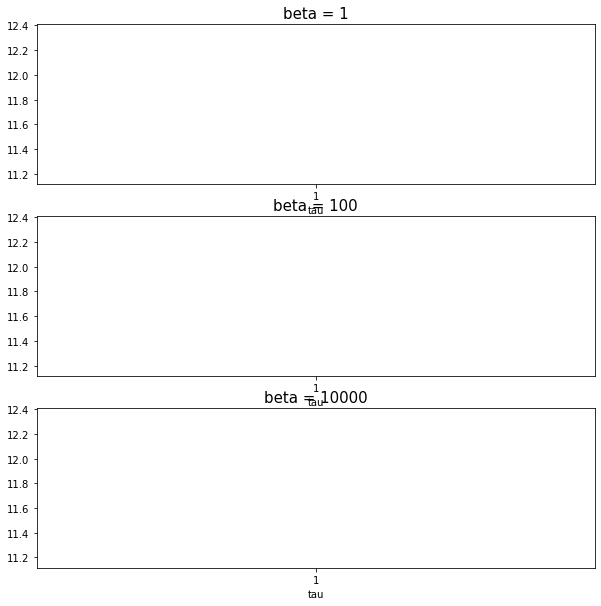

In [8]:
fig, ax = plt.subplots(len(betas),1, figsize =(10,10))
for b in range(len(betas)):
    beta_col = [c for c in df_optimized.columns if float(c.split("_")[0]) == betas[b]]
    for lam in scaling_lam:
        lam_col = [c for c in beta_col if float(c.split("_")[1]) == lam]
    
        df = df_optimized[lam_col]
        y = df.loc["Non-Man",:].values
        ax[b].plot(y)
        ax[b].set_xticks([i for i in range(len(scaling_tau))])
        ax[b].set_xticklabels(scaling_tau)
        
        ax[b].set_xlabel("tau")
        ax[b].set_title("beta = {}".format(betas[b]), fontsize = 15)

In [155]:
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = 10000)
# Reduce cost df to remove duplicate columns.
cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
cost_df

,"Woman, White","Woman, Asian","Woman, Hispanics of any race","Woman, Black or African American","Woman, American Indian or Alaska Native","Man, White","Man, Asian","Man, Hispanics of any race","Man, Black or African American","Man, Two or more races","Man, American Indian or Alaska Native"
aidekman,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anderson,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ballou,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
capen_house,0.106556,0.100392,0.104789,0.100981,0.099494,0.106678,0.105336,0.1063,0.0,0.06434,0.105135
clic,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dental_school,0.997715,0.0,0.0,0.0,0.002285,0.0,0.0,0.0,0.0,0.0,0.0
eaton_hall,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fine_arts_house,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gifford_house,0.5936,0.0,0.0,0.0,0.021127,0.0,0.0,0.0,0.0,0.0,0.385273
goddard_chapel,0.60566,0.0,0.0,0.0,0.017294,0.0,0.0,0.0,0.0,0.0,0.377046


In [88]:
df_opt_dict = { }
beta = .1

df_optimized2 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

# Compute cost matrix
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                hall_df = hall_df,
                                categories = ["gender","race"],
                                alpha = -1,
                                beta = beta)
# Reduce cost df to remove duplicate columns.
cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})

# Optimize assignment_df
scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])
scaling_tau = np.array([0.0,0.01, 0.1, 1, 10,100])

for p in scaling_lam:
    for q in scaling_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, current_assignment, 
                             lam = lam_factor*p, tau=tau_factor*q, init=1) # lambda, you can change this.

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized2[f"{p}_{q}"] = list(os_gender) + list(os_race)

In [91]:
df_opt_dict = { }
beta = 1

df_optimized3 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

# Compute cost matrix
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                hall_df = hall_df,
                                categories = ["gender","race"],
                                alpha = -1,
                                beta = beta)
# Reduce cost df to remove duplicate columns.
cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})

# Optimize assignment_df
scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])
scaling_tau = np.array([0.0,0.01, 0.1, 1, 10,100])

for p in scaling_lam:
    for q in scaling_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, current_assignment, 
                             lam = lam_factor*p, tau=tau_factor*q, init=1) # lambda, you can change this.

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized3[f"{p}_{q}"] = list(os_gender) + list(os_race)

In [89]:
df_opt_dict = { }
beta = 10

df_optimized4 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

# Compute cost matrix
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                hall_df = hall_df,
                                categories = ["gender","race"],
                                alpha = -1,
                                beta = beta)
# Reduce cost df to remove duplicate columns.
cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})

# Optimize assignment_df
scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])
scaling_tau = np.array([0.0,0.01, 0.1, 1, 10,100])

for p in scaling_lam:
    for q in scaling_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, current_assignment, 
                             lam = lam_factor*p, tau=tau_factor*q, init=1) # lambda, you can change this.

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized4[f"{p}_{q}"] = list(os_gender) + list(os_race)

In [92]:
df_opt_dict = { }
beta = 100

df_optimized5 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

# Compute cost matrix
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                hall_df = hall_df,
                                categories = ["gender","race"],
                                alpha = -1,
                                beta = beta)
# Reduce cost df to remove duplicate columns.
cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})

# Optimize assignment_df
scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])
scaling_tau = np.array([0.0,0.01, 0.1, 1, 10,100])

for p in scaling_lam:
    for q in scaling_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, current_assignment, 
                             lam = lam_factor*p, tau=tau_factor*q, init=1) # lambda, you can change this.

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized5[f"{p}_{q}"] = list(os_gender) + list(os_race)

In [90]:
df_opt_dict = { }
beta = 1000

df_optimized6 = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

# Compute cost matrix
cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                hall_df = hall_df,
                                categories = ["gender","race"],
                                alpha = -1,
                                beta = beta)
# Reduce cost df to remove duplicate columns.
cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})

# Optimize assignment_df
scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])
scaling_tau = np.array([0.0,0.01, 0.1, 1, 10,100])

for p in scaling_lam:
    for q in scaling_tau:
        assignment_df = sc.learn_optimal_assignment(cost_df, 
                             building_capacity_df, 
                             art_capacity_df, current_assignment, 
                             lam = lam_factor*p, tau=tau_factor*q, init=1) # lambda, you can change this.

        # Get optimized stats.
        os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
        os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
        df_optimized6[f"{p}_{q}"] = list(os_gender) + list(os_race)

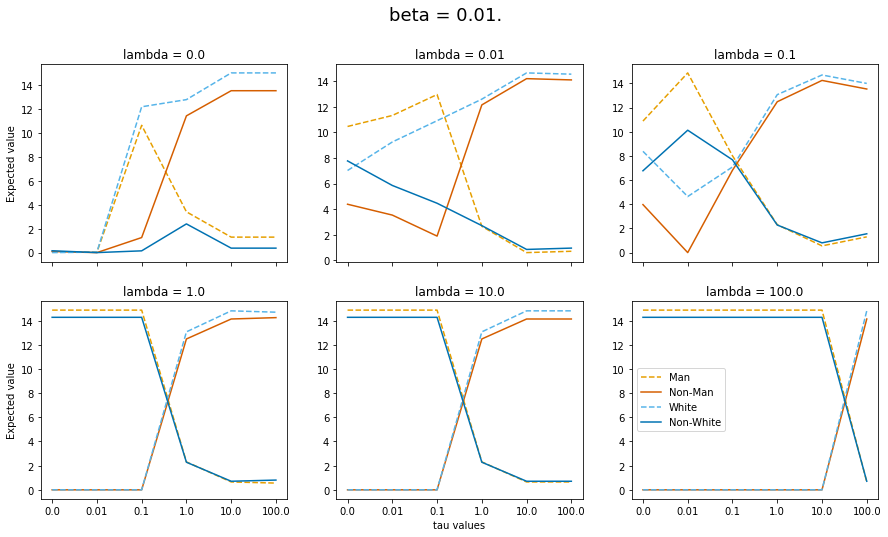

In [121]:
fig, ax = plt.subplots(2,3, sharex = True, figsize = (15,8))

scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])

for i in range(len(scaling_lam)):
    lam_col = [c for c in df_optimized1.columns if float(c.split("_")[0]) == scaling_lam[i]]
    tau_col = [float(c.split("_")[1]) for c in lam_col]

    ax[i//3,i%3].plot(df_optimized1.loc["Man",lam_col].values, label = "Man", color = COLOR_MAP["light_orange"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized1.loc["Non-Man",lam_col].values, label = "Non-Man", color = COLOR_MAP["dark_orange"])

    ax[i//3,i%3].plot(df_optimized1.loc["White",lam_col].values, label = "White", color = COLOR_MAP["light_blue"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized1.loc["Non-White",lam_col].values, label = "Non-White", color = COLOR_MAP["dark_blue"])

    ax[i//3,i%3].set_xticks([i for i in range(len(tau_col))])
    ax[i//3,i%3].set_xticklabels(tau_col)
    ax[i//3,i%3].set_title("lambda = {}".format(scaling_lam[i]))

    if i == 4:
        ax[i//3,i%3].set_xlabel("tau values")
        
    if i in [0,3]:
        ax[i//3,i%3].set_ylabel("Expected value")
    
plt.suptitle("beta = 0.01.", fontsize = 18)
plt.legend()
plt.show()

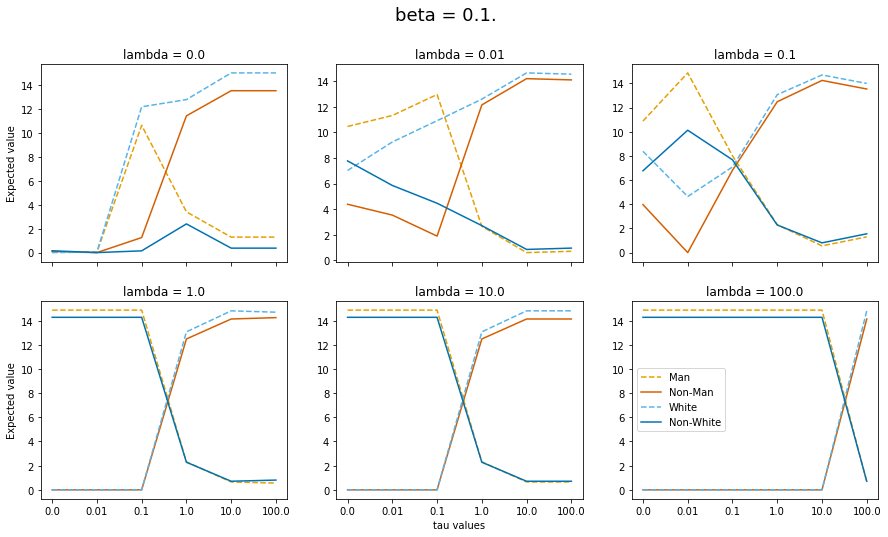

In [122]:
fig, ax = plt.subplots(2,3, sharex = True, figsize = (15,8))

scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])

for i in range(len(scaling_lam)):
    lam_col = [c for c in df_optimized2.columns if float(c.split("_")[0]) == scaling_lam[i]]
    tau_col = [float(c.split("_")[1]) for c in lam_col]

    ax[i//3,i%3].plot(df_optimized2.loc["Man",lam_col].values, label = "Man", color = COLOR_MAP["light_orange"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized2.loc["Non-Man",lam_col].values, label = "Non-Man", color = COLOR_MAP["dark_orange"])

    ax[i//3,i%3].plot(df_optimized2.loc["White",lam_col].values, label = "White", color = COLOR_MAP["light_blue"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized2.loc["Non-White",lam_col].values, label = "Non-White", color = COLOR_MAP["dark_blue"])

    ax[i//3,i%3].set_xticks([i for i in range(len(tau_col))])
    ax[i//3,i%3].set_xticklabels(tau_col)
    ax[i//3,i%3].set_title("lambda = {}".format(scaling_lam[i]))

    if i == 4:
        ax[i//3,i%3].set_xlabel("tau values")
        
    if i in [0,3]:
        ax[i//3,i%3].set_ylabel("Expected value")
    
plt.suptitle("beta = 0.1.", fontsize = 18)
plt.legend()
plt.show()

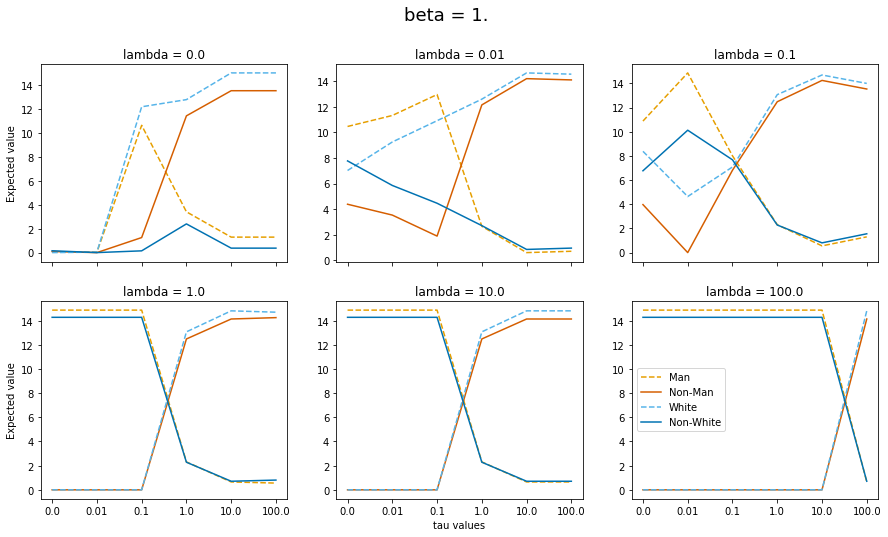

In [123]:
fig, ax = plt.subplots(2,3, sharex = True, figsize = (15,8))

scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])

for i in range(len(scaling_lam)):
    lam_col = [c for c in df_optimized3.columns if float(c.split("_")[0]) == scaling_lam[i]]
    tau_col = [float(c.split("_")[1]) for c in lam_col]

    ax[i//3,i%3].plot(df_optimized3.loc["Man",lam_col].values, label = "Man", color = COLOR_MAP["light_orange"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized3.loc["Non-Man",lam_col].values, label = "Non-Man", color = COLOR_MAP["dark_orange"])

    ax[i//3,i%3].plot(df_optimized3.loc["White",lam_col].values, label = "White", color = COLOR_MAP["light_blue"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized3.loc["Non-White",lam_col].values, label = "Non-White", color = COLOR_MAP["dark_blue"])

    ax[i//3,i%3].set_xticks([i for i in range(len(tau_col))])
    ax[i//3,i%3].set_xticklabels(tau_col)
    ax[i//3,i%3].set_title("lambda = {}".format(scaling_lam[i]))

    if i == 4:
        ax[i//3,i%3].set_xlabel("tau values")
        
    if i in [0,3]:
        ax[i//3,i%3].set_ylabel("Expected value")
    
plt.suptitle("beta = 1.", fontsize = 18)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(2,3, sharex = True, figsize = (15,8))

scaling_lam = np.array([0.0,0.01, 0.1, 1, 10,100])

for i in range(len(scaling_lam)):
    lam_col = [c for c in df_optimized3.columns if float(c.split("_")[0]) == scaling_lam[i]]
    tau_col = [float(c.split("_")[1]) for c in lam_col]

    ax[i//3,i%3].plot(df_optimized3.loc["Man",lam_col].values, label = "Man", color = COLOR_MAP["light_orange"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized3.loc["Non-Man",lam_col].values, label = "Non-Man", color = COLOR_MAP["dark_orange"])

    ax[i//3,i%3].plot(df_optimized3.loc["White",lam_col].values, label = "White", color = COLOR_MAP["light_blue"],
           linestyle = "--")
    ax[i//3,i%3].plot(df_optimized3.loc["Non-White",lam_col].values, label = "Non-White", color = COLOR_MAP["dark_blue"])

    ax[i//3,i%3].set_xticks([i for i in range(len(tau_col))])
    ax[i//3,i%3].set_xticklabels(tau_col)
    ax[i//3,i%3].set_title("lambda = {}".format(scaling_lam[i]))

    if i == 4:
        ax[i//3,i%3].set_xlabel("tau values")
        
    if i in [0,3]:
        ax[i//3,i%3].set_ylabel("Expected value")
    
plt.suptitle("beta = 1.", fontsize = 18)
plt.legend()
plt.show()

In [124]:
df_optimized1

,0.0_0.0,0.0_0.01,0.0_0.1,0.0_1.0,0.0_10.0,0.0_100.0,0.01_0.0,0.01_0.01,0.01_0.1,0.01_1.0,...,10.0_0.1,10.0_1.0,10.0_10.0,10.0_100.0,100.0_0.0,100.0_0.01,100.0_0.1,100.0_1.0,100.0_10.0,100.0_100.0
Man,0.039063,3.964589e-02,10.630187,3.407091,1.292834,1.292834,10.466818,11.326919,12.966293,2.654307,...,14.869919,2.309885,0.650548,0.650548,14.869919,14.869919,14.869919,14.869919,14.869919,0.650548
Non-Man,0.091322,8.480678e-18,1.257821,11.421680,13.521639,13.521639,4.381361,3.532398,1.887596,12.154191,...,0.000000,12.482535,14.134511,14.134511,0.000000,0.000000,0.000000,0.000000,0.000000,14.134511
White,0.000000,3.925684e-02,12.179540,12.777365,15.008672,15.008672,7.021645,9.252431,10.917989,12.605176,...,0.000000,13.070683,14.809906,14.809906,0.000000,0.000000,0.000000,0.000000,0.000000,14.809906
Non-White,0.154197,1.101499e-03,0.147357,2.397597,0.373218,0.373218,7.771293,5.851173,4.458983,2.707581,...,14.274079,2.283882,0.708295,0.708295,14.274079,14.274079,14.274079,14.274079,14.274079,0.708295


In [125]:
df_optimized2

,0.0_0.0,0.0_0.01,0.0_0.1,0.0_1.0,0.0_10.0,0.0_100.0,0.01_0.0,0.01_0.01,0.01_0.1,0.01_1.0,...,10.0_0.1,10.0_1.0,10.0_10.0,10.0_100.0,100.0_0.0,100.0_0.01,100.0_0.1,100.0_1.0,100.0_10.0,100.0_100.0
Man,0.039063,3.964589e-02,10.630187,3.407091,1.292834,1.292834,10.466818,11.326919,12.966293,2.654307,...,14.869919,2.309885,0.650548,0.650548,14.869919,14.869919,14.869919,14.869919,14.869919,0.650548
Non-Man,0.091322,8.480678e-18,1.257821,11.421680,13.521639,13.521639,4.381361,3.532398,1.887596,12.154191,...,0.000000,12.482535,14.134511,14.134511,0.000000,0.000000,0.000000,0.000000,0.000000,14.134511
White,0.000000,3.925684e-02,12.179540,12.777365,15.008672,15.008672,7.021645,9.252431,10.917989,12.605176,...,0.000000,13.070683,14.809906,14.809906,0.000000,0.000000,0.000000,0.000000,0.000000,14.809906
Non-White,0.154197,1.101499e-03,0.147357,2.397597,0.373218,0.373218,7.771293,5.851173,4.458983,2.707581,...,14.274079,2.283882,0.708295,0.708295,14.274079,14.274079,14.274079,14.274079,14.274079,0.708295
